In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf 

In [2]:
# Load the dataset with train, validation, and test splits
train_dataset, val_dataset = tfds.load(
    'oxford_iiit_pet',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True  # Returns (image, label) pairs
)
test_dataset = tfds.load(
    'oxford_iiit_pet',
    split='test',
    as_supervised=True
)

In [3]:
# Preprocessing function to resize and normalize images
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Apply preprocessing to the datasets
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Verify the dataset structure
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)  # Should be (batch_size, 224, 224, 3)
    print("Label batch shape:", labels.shape)  # Should be (batch_size,)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


2025-04-03 12:18:02.009627: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-03 12:18:02.035732: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# Apply Data Augmentation 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

In [5]:
# Create the base model from pre-trained VGG16
base_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
# Freeze the base model
base_model.trainable = False

# Create the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(37, activation='softmax')
])

In [6]:
# COMPILE MODEL
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         9,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,855,525 (56.67 MB)

 Trainable params: 140,837 (550.14 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [52]:
# TRAIN THE MODEL
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.0399 - loss: 3.6935 - val_accuracy: 0.0856 - val_loss: 3.4913
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.0659 - loss: 3.4876 - val_accuracy: 0.1304 - val_loss: 3.2889
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.0966 - loss: 3.3311 - val_accuracy: 0.1821 - val_loss: 3.0796
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.1262 - loss: 3.1680 - val_accuracy: 0.2052 - val_loss: 2.8821
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.1583 - loss: 3.0165 - val_accuracy: 0.2812 - val_loss: 2.7156
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.1862 - loss: 2.8814 - val_accuracy: 0.2989 - val_loss: 2.5804
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.1997 - loss: 2.7914 - val_accuracy: 0.3193 - val_loss: 2.4792
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.2308 - loss: 2.6634 - val_accuracy: 0.3410 - v

In [53]:
# EVALUATE THE MODEL
# Preprocess test dataset
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.4745 - loss: 1.8018
Test accuracy: 0.46252384781837463


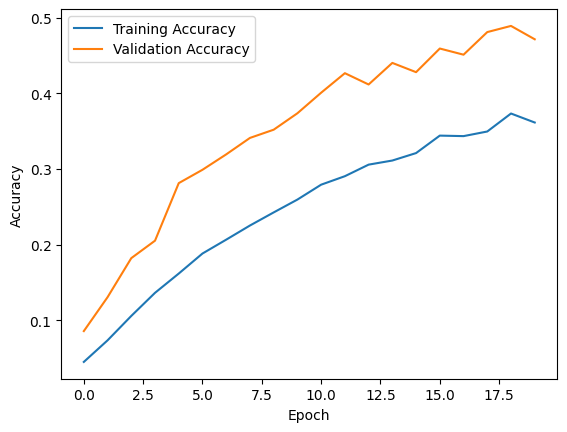

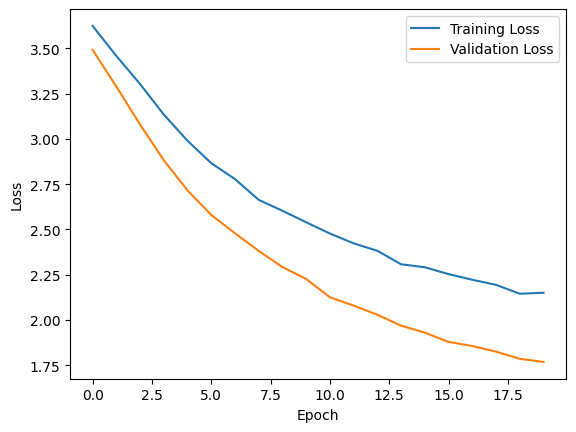

In [54]:
# PLOT TRAINING HISTORY
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
# Save the model
model.save('oxford_iiit_pet_model1.h5')


In [7]:
import tensorflow as tf
import os
from datetime import datetime
import csv


# Create directories for logs
log_dir = "results/logs"
os.makedirs(log_dir, exist_ok=True)

# Create CSV logger
csv_logger = tf.keras.callbacks.CSVLogger(
    os.path.join(log_dir, f'training_log_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
)

# Create TensorBoard callback
tensorboard_dir = os.path.join(log_dir, 'tensorboard')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_dir,
    histogram_freq=1
)

# Update your training code
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[csv_logger, tensorboard_callback]
)

# Save history dictionary as JSON
import json
history_dir = os.path.join(log_dir, 'history')
os.makedirs(history_dir, exist_ok=True)
with open(os.path.join(history_dir, f'history_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'), 'w') as f:
    json.dump(history.history, f)



Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.0337 - loss: 3.6846 - val_accuracy: 0.1046 - val_loss: 3.4496
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.0783 - loss: 3.4602 - val_accuracy: 0.1685 - val_loss: 3.2512
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.1200 - loss: 3.2716 - val_accuracy: 0.2174 - val_loss: 3.0013
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.1409 - loss: 3.1201 - val_accuracy: 0.2500 - val_loss: 2.8106
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.1965 - loss: 2.9236 - val_accuracy: 0.2812 - val_loss: 2.6692
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.2129 - loss: 2.8251 - val_accuracy: 0.3193 - val_loss: 2.5154
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.2345 - loss: 2.7213 - val_accuracy: 0.3383 - val_loss: 2.4263
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.2474 - loss: 2.6389 - val_accuracy: 0.3655 - v